# Import the dependencies and provide inputs
1. Input specify the pathdir variable so that it points to the directory were i have the OF results with timesteps.
2. listdir('../DMD_predictions')
3. Specify grid size:  It is 2D simulation or 3D with single grid in third direction.Grid size:  n  = [120,70] , nx and ny.
4. startt
5. r : number of modes 6 The polymesh folder should have same number of cells

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import warnings
warnings.filterwarnings('ignore')
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import math as math
from matplotlib import animation, rc
from IPython.display import HTML, Image

In [3]:
import os
import sys
from os.path import isdir, isfile, join
import numpy as np
import re

pathdir = './Re265'
n       = [120,70] # grid size
startt=1

def read_field_from_file(time, field):
    resultFile = open(join(pathdir, time, field))
    
    print(resultFile)
#    import time
#    time.sleep(10)

    content = resultFile.readlines() # read entire file into memory
    resultFile.close()
    npt     = int(content[20])       # number of result points hardcoded to line 21

    # if results are within (), then they are vector values
    if content[22][0] == '(':
        return np.array([np.fromstring(value[1:-1], sep=' ') for value in content[22:22+npt]])
    # else scalar values
    else:
        return np.array([float(value)                        for value in content[22:22+npt]])


def read_input_case(path):
    list_of_number_folders = [d for d in os.listdir(path) if re.match('\d', d)]
    time_steps = sorted(list_of_number_folders, key=lambda x: float(x))

    U   = np.zeros((len(time_steps)-1, n[0], n[1], 3))
    print(U.shape)
    P   = np.zeros((len(time_steps)-1, n[0], n[1], 1))
    ncase = len(time_steps)-2
    print('Reading example ', path, ':[                    ]', end='', flush=True)
    # sys.stdout.flush()
    
    for i,t in enumerate(time_steps[1:]): # skip t=0 since this only contains meta information
        u = read_field_from_file(t, 'U')
        p = read_field_from_file(t, 'p')
        #print(u.shape,'ushape')
        U[i,:,:,:] = np.reshape(u, (n[0],n[1],3), order='F')
        P[i,:,:,:] = np.reshape(p, (n[0],n[1],1), order='F')
        j = int(i/ncase*20)
        print(''.join(['\b']*21 + ['#']*j + [' ']*(20-j) + [']']), end='', flush=True)
    print()

    t = [float(t) for t in time_steps[1:]]

    return (U,P,t)


if __name__ == '__main__':
    # read the test data from file
    (U,P,t) = read_input_case(pathdir)
    U1=U[startt:,:,:,0]
    U=U[startt:,:,:,:]
    P=P[startt:,:,:,:]
    print(U.shape)
    t=t[startt:]
#    print(len(t))
    U11=U1
#    print(U.shape)
#    print(len(t))
#    print(P.shape)
    # append the pressure as a solution field
    U = np.append(U, P, axis=3)

    # flatten input so all variables are mashed together (as a vector) for every timestep
    U = np.reshape(U, (len(t), n[0]*n[1]*4))
    P1 = np.reshape(P, (len(t), n[0]*n[1]))
    U1 = np.reshape(U1, (len(t), n[0]*n[1]))
    print('U1shape')
    print(U1.shape)
    
    print('P1shape') 
    print(P1.shape)
   
  # transpose so time is your second axis
    U = U.transpose()
    P1 = P1.transpose()
    U1 = U1.transpose()
  
 # check that the dimensions are (33600, 195)
    print(U1.shape)


(5, 120, 70, 3)
Reading example  ./Re265 :[                    ]<_io.TextIOWrapper name='./Re265/101./U' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='./Re265/101./p' mode='r' encoding='UTF-8'>
                    ]<_io.TextIOWrapper name='./Re265/102.0/U' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='./Re265/102.0/p' mode='r' encoding='UTF-8'>
#####               ]<_io.TextIOWrapper name='./Re265/103./U' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='./Re265/103./p' mode='r' encoding='UTF-8'>
##########          ]<_io.TextIOWrapper name='./Re265/104.2/U' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='./Re265/104.2/p' mode='r' encoding='UTF-8'>
###############     ]<_io.TextIOWrapper name='./Re265/105./U' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='./Re265/105./p' mode='r' encoding='UTF-8'>
####################]
(4, 120, 70, 3)
U1shape
(4, 8400)
P1shape
(4, 8400)
(8400, 4)


plt.imshow(U11[177,:,:],cmap='hsv',extent=[-20,80,-20,20])
plt.show()

from pylab import *
pcolor(U11[1,:,:])
plt.show()

In [4]:
#plt.imshow(U1[190,:,:].T,cmap='hsv',extent=[-20,80,-20,20])
#origin='lower',
#plt.show()
#print(P1.shape)

In [5]:
# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

# Function for conducing DMD
* Take the Singular Value Decomposition of X
$$X\approx U\Sigma V^{*}$$

* Truncate to low rank r

* Compute $\tilde{A}$

$$\tilde{A}=U^{*}X^{'}V\Sigma^{-1}$$

* Compute the eigendecomposition of $\tilde{A}$

$$\tilde{A}W=W\Lambda$$

* Reconstruct the eigendecomposition of $A$ from $W$ and $\Lambda$

$$\Phi=X^{'}V\Sigma^{-1}W$$

In [6]:
def dmd(X,Xprime,r):
    U,S,V = np.linalg.svd(X,full_matrices=False,compute_uv=True)
    S=np.diag(S)
    V=V.T
    U=U[:,:r]
    S=S[:r,:r]
    V=V[:,:r]
    Atilde = U.T.conj().dot(Xprime).dot(V).dot(np.linalg.inv(S))
    eigs, W = np.linalg.eig(Atilde)
    eigs=np.diag(eigs)
    Phi = Xprime.dot(V).dot(np.linalg.inv(S)).dot(W)
    return Phi,eigs, W

# Plotting the eigen modes

In [7]:
def plot_all_cylinder(s,r):
    theta = np.linspace(0,1,100)
    theta = theta * 2*22.0/7.
    x = 49.0+25.0*np.sin(theta)
    y = 99.0+25.0*np.cos(theta)
    counter = 0
    plt.figure(figsize = (20,50))
    for i in range (0,r,2):
        counter = counter +1
        plt.subplot(r,2,counter)
        plt.imshow(np.real(s[:,:,i].T),cmap='hsv')
        #plt.fill(x,y)
        counter = counter + 1
        plt.subplot(r,2,counter)
        plt.imshow(np.imag(s[:,:,i].T),cmap='hsv')
        #plt.fill(x,y)
    plt.show()

In [8]:
def plot_all_cylinder_vort(s,r):
    theta = np.linspace(0,1,100)
    theta = theta * 2*22.0/7.
    x = 49.0+25.0*np.sin(theta)
    y = 99.0+25.0*np.cos(theta)
    counter = 0
    plt.figure(figsize = (20,50))
    for i in range (0,r):
        counter = counter +1
        plt.subplot(r,2,counter)
        plt.imshow(s[counter-1,:,:,0].T,cmap='hsv')
        #plt.fill(x,y)
        counter = counter + 1
        plt.subplot(r,2,counter)
        plt.imshow(s[counter,:,:,0].T,cmap='hsv')
        #plt.fill(x,y)
    plt.show()

In [9]:
np.shape(P1)

(8400, 4)

In [10]:
#plt.figure(figsize = (20,50))
#plt.subplot(1,1,1)
#plt.imshow(P[1,:,:,0].T,cmap='hsv',extent=[-20,80,-20,20])
#plt.show()
#plot_all_cylinder_vort(P1,r)

# Read the CFD results snapshots

In [11]:
#contents=sio.loadmat('./CYLINDER_ALL.mat')
#nx,ny,m,n = contents['nx'],contents['ny'],contents['m'],contents['n']
#VORTALL = contents['VORTALL']
#X  = VORTALL[:,0:150]
#X2 = VORTALL[:,1:151
length,end=np.shape(P1)
X=U1[:,0:end-1]
X2=U1[:,1:end]
#m, n = np.asscalar(m), np.asscalar(n)
#nx, ny = np.asscalar(nx), np.asscalar(ny)
nx=70
ny=120

In [12]:
length

8400

In [13]:
np.shape(X)

(8400, 3)

In [14]:
#Xorg = np.reshape(X,(ny,nx,end))
#plot_all_cylinder_vort(Xorg,20)

# We want to retain the 4 modes only

In [15]:
r =3

# Conduct Dynamic Mode Decomposition

In [16]:
# Phi is the eigen modes, eigs is the eigenvalues and W is the eigenvector
Phi, eigs, W = dmd(X,X2,r)

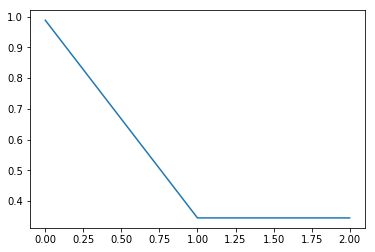

In [17]:
#Confirm if the modes are sorted
#plt.figure(figsize = (10,20))
plt.plot(np.diag(np.real(eigs)))
plt.show()

# Sort the eigen modes in the decreasing content of the energy

In [18]:
temp_eigs = np.diag(eigs)
idx = temp_eigs.argsort()[::-1]
temp_eigs = temp_eigs[idx]
eigs = np.diag(temp_eigs)
Phi = Phi[:,idx]

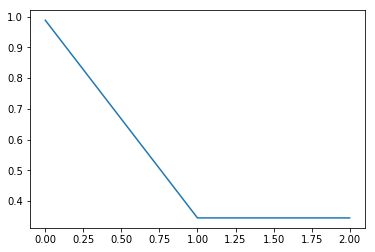

In [19]:
plt.plot(np.diag(np.real(eigs)))
plt.show()

In [20]:
Phi[190,::]

array([ 0.01164708+0.j        , -0.00024024-0.00016001j,
       -0.00024024+0.00016001j])

# Plot the eigen modes

In [21]:
print(Phi.shape)
Phi = np.reshape(Phi,(ny,nx,r))
print(Phi.shape)
#plot_all_cylinder(Phi,r)

(8400, 3)
(120, 70, 3)


In [22]:
Phi[110,69,1]

(0.0010671521262314953+8.6303318283357613e-05j)

## In the next section, the computed eigen modes are treated as scalar (pressure) and written in OF format so that they can be visualized by paraview. 

In [23]:
import os
import sys
from os.path import isdir, isfile, join
import numpy as np
import re

In [24]:
def read_file_prefix(time, field):
    resultFile = open(join(pathdir, time, field))
    content = resultFile.readlines() # read entire file into memory
    resultFile.close()
    return content[:22]


def read_file_postfix(time, field):
    resultFile = open(join(pathdir, time, field))
    content = resultFile.readlines() # read entire file into memory
    resultFile.close()
    npt     = int(content[20])       # number of result points hardcoded to line 21
    return content[22+npt:]





if __name__ == '__main__':
    list_of_number_folders = [d for d in os.listdir('./DMD_predictions') if re.match('\d', d)]
    print('list',list_of_number_folders)
    time_steps = sorted(list_of_number_folders, key=lambda x: float(x))
    print(time_steps)
    #print(time_steps[0])
    prefix_u  = read_file_prefix( str(time_steps[0]), 'U')
    postfix_u = read_file_postfix(str(time_steps[0]), 'U')
    prefix_p  = read_file_prefix( str(time_steps[0]), 'p')
    postfix_p = read_file_postfix(str(time_steps[0]), 'p')

    t10=time_steps[0]
    path1="./DMD_predictions"
if not os.path.exists(path1):
    os.mkdir(path1);
path1="./DMD_predictions/" + str(t10)
if not os.path.exists(path1):
    os.mkdir(path1);
    
for Ph in range(Phi.shape[-1]):
    # print(Ph)
    for k,t0 in enumerate(time_steps):
        # print progress info
        print(t0)

        folder = join('./DMD_predictions', str(t0))


        U  = np.zeros((120,70,3)) # INPUT YOUR VELOCITY RESULTS ARRAY HERE
        
        #P  = np.zeros((120,70,1)) # INPUT YOUR PRESSURE RESULTS ARRAY HERE
        
        #INPUT YOUR PHI BELOW INPLACE OF PRESSURE
        
        P=np.real(Phi[:,:,:])
    
        
        ## write velocity predictions (time series)
        #resultFile = open(join(folder, 'V'), 'w')
        #resultFile.writelines(prefix_u)
        #for j in range(n[1]):
        #    for i in range(n[0]):
        #        resultFile.write('('+' '.join(map(str,U[i,j,:]))+')\n')
        #resultFile.writelines(postfix_u)
        #resultFile.close()

        # write pressure predictions (time series)
        resultFile = open(join(folder, 'q'+str(Ph)), 'w')
        resultFile.writelines(prefix_p)
        for j in range(n[1]):
            for i in range(n[0]):
                resultFile.write(str(P[i,j,Ph])+'\n')
        resultFile.writelines(postfix_p)
        resultFile.close()

list ['101.']
['101.']
101.
101.
101.


def plot_cylinder(s):
    plt.figure()
    plt.imshow(s,cmap='hsv',hold='on')
    theta = np.linspace(0,1,100)
    theta = theta * 2*22.0/7.
    x = 49.0+25.0*np.sin(theta)
    y = 99.0+25.0*np.cos(theta)
    plt.fill(x,y)
    plt.show()


# ## After loading in paraview. Save the screenshot as png and you can see them here. 

from IPython.display import Image
from IPython.display import display
#image.open(../DMD_predictions/q0)
a=Image(filename='../DMD_predictions/q0.png')
b=Image(filename='../DMD_predictions/q2.png')
c=Image(filename='../DMD_predictions/q4.png')
d=Image(filename='../DMD_predictions/q6.png')
display(a,b)
display(c,d)

import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

images = []
for img_path in glob.glob('../DMD_predictions/*.png'):
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)